In [1]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 
    

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.90
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [80]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential

In [81]:
file_name = 'AEP_hourly.csv'
df = pd.read_csv(file_name,index_col='Datetime',parse_dates=True)
df = (df.reset_index()
        .drop_duplicates(subset='Datetime', keep='last')
        .set_index('Datetime').sort_index())

In [82]:
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [83]:
df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [84]:
df.tail()

,AEP_MW
Datetime,
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0
2018-08-02 23:00:00,15964.0
2018-08-03 00:00:00,14809.0


<AxesSubplot:xlabel='Datetime'>

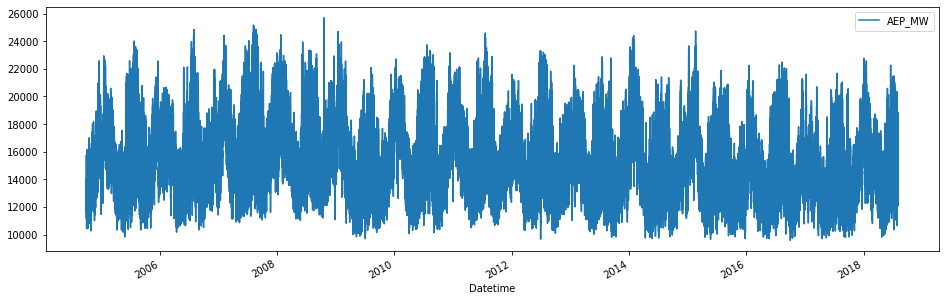

In [85]:
df.plot(figsize=(16,5))

In [86]:
df.describe()

,AEP_MW
count,121269.000000
mean,15499.651090
std,2591.325461
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


# copy dataframe and fill missing dates with nan

In [87]:
from datetime import datetime
dt = pd.date_range(start='2004-10-01 01:00:00',end='2018-08-03 00:00:00',freq='H').tolist()
df2 = pd.DataFrame(dt,columns=['date'])
df2.set_index('date',inplace=True)
df2['MW'] = 'nan'
print(df2)

                      MW
date                    
2004-10-01 01:00:00  nan
2004-10-01 02:00:00  nan
2004-10-01 03:00:00  nan
2004-10-01 04:00:00  nan
2004-10-01 05:00:00  nan
...                  ...
2018-08-02 20:00:00  nan
2018-08-02 21:00:00  nan
2018-08-02 22:00:00  nan
2018-08-02 23:00:00  nan
2018-08-03 00:00:00  nan

[121296 rows x 1 columns]


In [88]:
for ind in range(len(df)):
    df2.loc[str(df.index[ind])] = df.loc[str(df.index[ind])][0]

In [89]:
df2.index.freq="H"

In [90]:
df2

,MW
date,
2004-10-01 01:00:00,12379
2004-10-01 02:00:00,11935
2004-10-01 03:00:00,11692
2004-10-01 04:00:00,11597
2004-10-01 05:00:00,11681
...,...
2018-08-02 20:00:00,17673
2018-08-02 21:00:00,17303
2018-08-02 22:00:00,17001


In [91]:
for ind in range(len(df2)):
    if(df2.loc[str(df2.index[ind])][0] is 'nan'):
        df2.loc[str(df2.index[ind])][0] = df2.loc[str(df2.index[ind-1])][0]

In [92]:
df2['MW']

date
2004-10-01 01:00:00    12379
2004-10-01 02:00:00    11935
2004-10-01 03:00:00    11692
2004-10-01 04:00:00    11597
2004-10-01 05:00:00    11681
                       ...  
2018-08-02 20:00:00    17673
2018-08-02 21:00:00    17303
2018-08-02 22:00:00    17001
2018-08-02 23:00:00    15964
2018-08-03 00:00:00    14809
Freq: H, Name: MW, Length: 121296, dtype: object

<AxesSubplot:xlabel='date'>

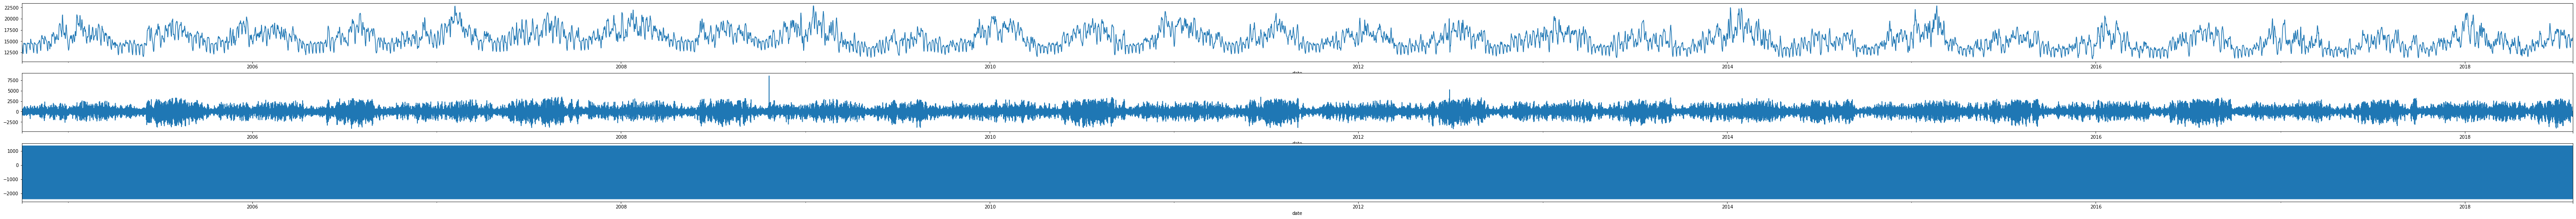

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 

results = seasonal_decompose(df2['MW'])


fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(100,8))
results.trend.plot(ax=ax1)
results.resid.plot(ax=ax2)
results.seasonal.plot(ax=ax3)

<AxesSubplot:xlabel='date'>

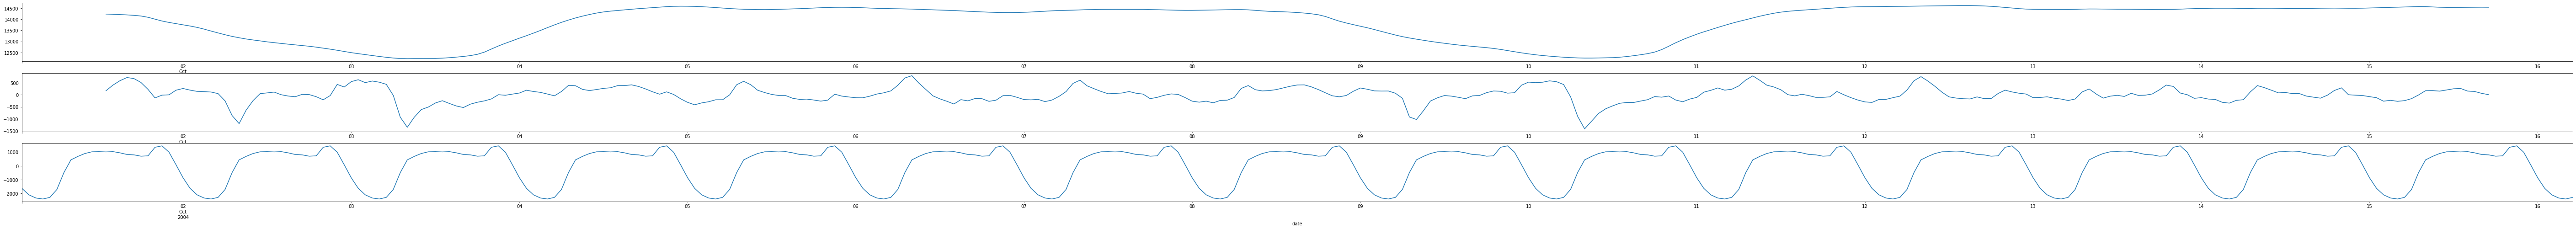

In [94]:
results_snap = seasonal_decompose(df2[:365]['MW'])


fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(100,8))
results_snap.trend.plot(ax=ax1)
results_snap.resid.plot(ax=ax2)
results_snap.seasonal.plot(ax=ax3)

<AxesSubplot:xlabel='date'>

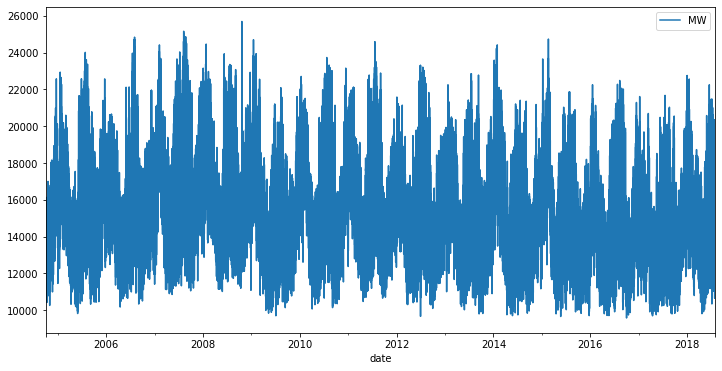

In [95]:
df2.plot(figsize=(12,6))

In [96]:
df = df2

In [97]:
scaler = sklearn.preprocessing.MinMaxScaler()
df2['MW'] = scaler.fit_transform(df2['MW'].values.reshape(-1,1))
df2.shape

(121296, 1)

In [98]:
def load_data(data_frame, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(data_frame)):
        X_train.append(data_frame.iloc[i-seq_len : i, 0])
        y_train.append(data_frame.iloc[i, 0])
    
    #1 last 5366 days are going to be used in test
    X_test = X_train[-8760:]             
    y_test = y_train[-8760:]
    
    #2 first 140000 days are going to be used in training
    X_train = X_train[:-8760]          
    y_train = y_train[:-8760]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [131]:
seq_len = 360 

X_train, y_train, X_test, y_test = load_data(df2, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (112176, 360, 1)
y_train.shape =  (112176,)
X_test.shape =  (8760, 360, 1)
y_test.shape =  (8760,)


In [132]:
lstm_model = Sequential()

lstm_model.add(LSTM(100,activation="tanh", input_shape=(X_train.shape[1],1)))
#lstm_model.add(Dropout(0.2))

#lstm_model.add(LSTM(50,activation="tanh",return_sequences=True))
#lstm_model.add(Dropout(0.2))

#lstm_model.add(LSTM(50,activation="tanh",return_sequences=True))
#lstm_model.add(Dropout(0.2))

#lstm_model.add(LSTM(50,activation="tanh",return_sequences=False))
#lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [133]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
3506/3506 [==============================] - 50s 14ms/step - loss: 0.0014
Epoch 2/10
3506/3506 [==============================] - 50s 14ms/step - loss: 2.5190e-04
Epoch 3/10
3506/3506 [==============================] - 50s 14ms/step - loss: 2.3357e-04
Epoch 4/10
3506/3506 [==============================] - 50s 14ms/step - loss: 2.0114e-04 0s - lo
Epoch 5/10
3506/3506 [==============================] - 50s 14ms/step - loss: 1.8010e-04
Epoch 6/10
3506/3506 [==============================] - 50s 14ms/step - loss: 1.6428e-04
Epoch 7/10
3506/3506 [==============================] - 50s 14ms/step - loss: 1.5266e-04
Epoch 8/10
3506/3506 [==============================] - 50s 14ms/step - loss: 1.4432e-04
Epoch 9/10
3506/3506 [==============================] - 50s 14ms/step - loss: 1.3522e-04
Epoch 10/10
3506/3506 [==============================] - 50s 14ms/step - loss: 1.2929e-04


In [134]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9950557426088006


In [135]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='red',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

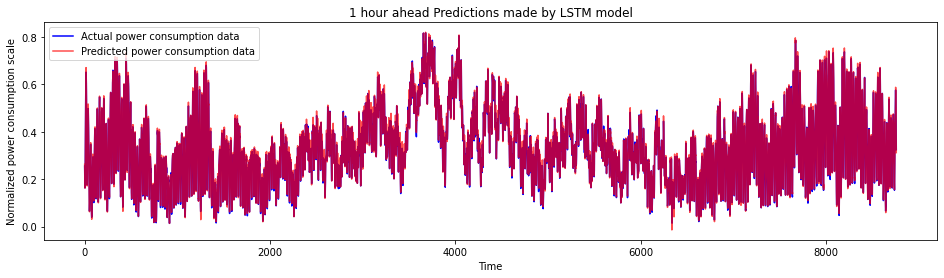

In [136]:

plot_predictions(y_test, lstm_predictions, "1 hour ahead Predictions made by LSTM model")

In [137]:
x_time = df2.index[-8760:]
print(x_time)

DatetimeIndex(['2017-08-03 01:00:00', '2017-08-03 02:00:00',
               '2017-08-03 03:00:00', '2017-08-03 04:00:00',
               '2017-08-03 05:00:00', '2017-08-03 06:00:00',
               '2017-08-03 07:00:00', '2017-08-03 08:00:00',
               '2017-08-03 09:00:00', '2017-08-03 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='date', length=8760, freq='H')


In [138]:
y_test_org = scaler.inverse_transform(y_test.reshape(-1,1))

In [139]:
predicted_mw = scaler.inverse_transform(lstm_predictions.reshape(-1,1))

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_test_org,predicted_mw)

29394.996777785207

In [141]:
mean_absolute_error(y_test_org,predicted_mw)

127.47298478078625

In [142]:
len(y_test_org)

8760

In [143]:
len(predicted_mw)

8760

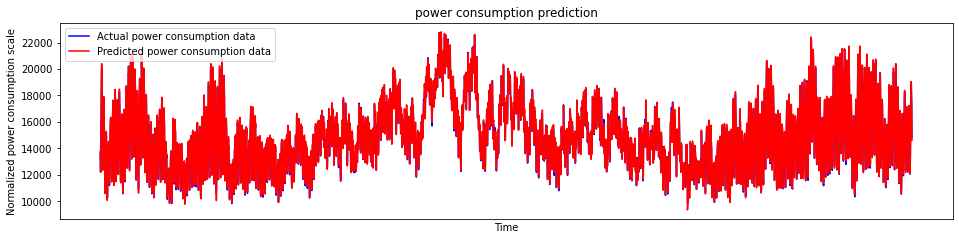

In [144]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(16,4))
ax1= fig.add_subplot(111)
plt.xticks()
plt.plot(x_time ,y_test_org,color='blue',label='Actual power consumption data')
plt.plot(x_time,predicted_mw, color='red',label='Predicted power consumption data')
tick_spacing = 1000
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.title("power consumption prediction")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

# 24 hour prediction 

In [145]:
X_train[0].shape

(360, 1)

In [146]:
last_train_batch = X_train[-1]

In [147]:
last_train_batch = last_train_batch.reshape((1,seq_len,1))

In [148]:
lstm_model.predict(last_train_batch)

array([[0.31891423]], dtype=float32)

In [149]:
y_test[0]

0.2544991932481072

In [150]:
test_predictions = []
first_eval_batch = X_train[-1]
current_batch = first_eval_batch.reshape((1,seq_len,1))


for i in range(24):
    current_pred = lstm_model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [151]:
test_predictions

[array([0.31891423], dtype=float32),
 array([0.25616932], dtype=float32),
 array([0.21542574], dtype=float32),
 array([0.19070503], dtype=float32),
 array([0.17979047], dtype=float32),
 array([0.1851227], dtype=float32),
 array([0.20771687], dtype=float32),
 array([0.244214], dtype=float32),
 array([0.29313248], dtype=float32),
 array([0.3512498], dtype=float32),
 array([0.4116211], dtype=float32),
 array([0.4676695], dtype=float32),
 array([0.51737267], dtype=float32),
 array([0.5623034], dtype=float32),
 array([0.6006843], dtype=float32),
 array([0.630525], dtype=float32),
 array([0.65378135], dtype=float32),
 array([0.6700837], dtype=float32),
 array([0.6703581], dtype=float32),
 array([0.64599264], dtype=float32),
 array([0.6138032], dtype=float32),
 array([0.5977647], dtype=float32),
 array([0.5549873], dtype=float32),
 array([0.4658954], dtype=float32)]

In [152]:
true_predictions = scaler.inverse_transform(test_predictions)

In [153]:
true_predictions

array([[14719.98397696],
       [13708.91240883],
       [13052.37044933],
       [12654.02087206],
       [12478.14358562],
       [12564.06716436],
       [12928.14960012],
       [13516.26436889],
       [14304.53684652],
       [15241.03950334],
       [16213.86230469],
       [17117.02611351],
       [17917.94316876],
       [18641.95737243],
       [19260.42657113],
       [19741.27973628],
       [20116.03274524],
       [20378.72876775],
       [20383.15076816],
       [19990.52534747],
       [19471.82489169],
       [19213.37990606],
       [18524.06553531],
       [17088.43870687]])

In [154]:
len(true_predictions)

24

In [155]:
true_y = scaler.inverse_transform([y_test])

In [156]:
true_y

array([[13682., 12841., 12443., ..., 17001., 15964., 14809.]])

In [157]:
true_predictions = true_predictions.reshape(1,24)

In [158]:
true_predictions[0]

array([14719.98397696, 13708.91240883, 13052.37044933, 12654.02087206,
       12478.14358562, 12564.06716436, 12928.14960012, 13516.26436889,
       14304.53684652, 15241.03950334, 16213.86230469, 17117.02611351,
       17917.94316876, 18641.95737243, 19260.42657113, 19741.27973628,
       20116.03274524, 20378.72876775, 20383.15076816, 19990.52534747,
       19471.82489169, 19213.37990606, 18524.06553531, 17088.43870687])

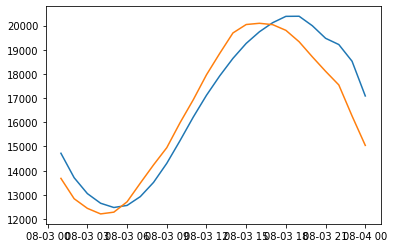

In [159]:
plt.plot(x_time[:24],true_predictions[0])
plt.plot(x_time[:24],true_y[0][:24])

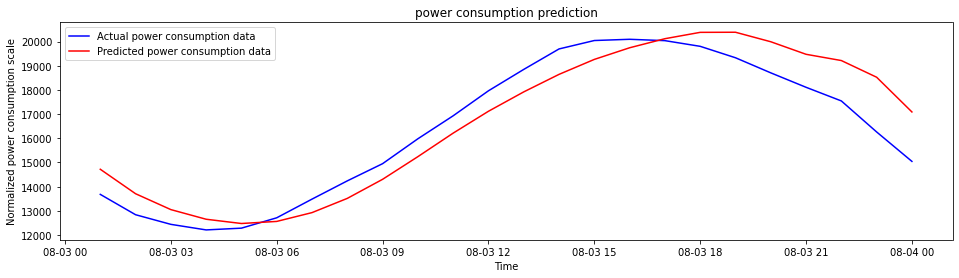

In [160]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(16,4))
ax1= fig.add_subplot(111)
plt.plot(x_time[:24],true_y[0][:24],color='blue',label='Actual power consumption data')
plt.plot(x_time[:24],true_predictions[0], color='red',label='Predicted power consumption data')
# beautify the x-labels
plt.title("power consumption prediction")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()